In [1]:
from clearsky.main import StatisticalClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}

In [2]:
from os.path import expanduser
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')

In [3]:
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')

In [4]:
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TAEAC1031314')
        and meas_name = 'ac_power'
        and ts < '2018-2-2';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)

In [5]:
df = make_time_series(df, return_keys=False).fillna(0)

In [6]:
df.head()

,ac_power_01,ac_power_02
2015-06-25 12:05:00,5.8735,0.0
2015-06-25 12:10:00,5.9283,0.0
2015-06-25 12:15:00,0.0000,0.0
2015-06-25 12:20:00,5.9920,0.0
2015-06-25 12:25:00,0.0000,0.0


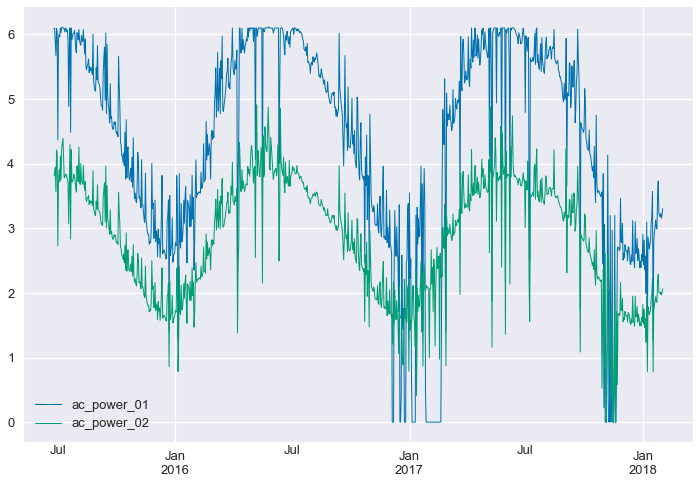

In [7]:
df.resample('D').max().plot(**PLOT_ARGS)

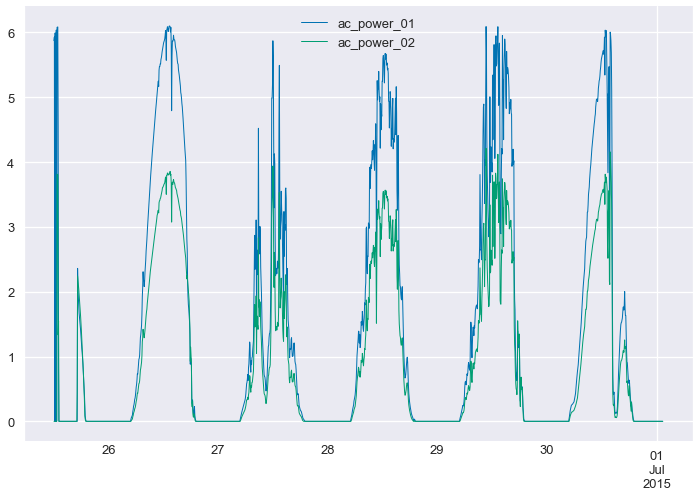

In [8]:
df.iloc[:1600].plot(**PLOT_ARGS)

In [9]:
df.loc[:'1/31/18'].tail()

,ac_power_01,ac_power_02
2018-01-31 23:35:00,0.0,0.0
2018-01-31 23:40:00,0.0,0.0
2018-01-31 23:45:00,0.0,0.0
2018-01-31 23:50:00,0.0,0.0
2018-01-31 23:55:00,0.0,0.0


In [10]:
start = df.resample('D').max().index[1]

In [11]:
scs = StatisticalClearSky(df.loc[start:'1/31/18']['ac_power_01'])

In [12]:
ks = np.arange(5, 101, 5)
errors = np.empty_like(ks, dtype=float)
max_count = len(errors) - 1
bar_width = 40
for ind, k in enumerate(ks):
    scs.make_clearsky_model(n=k, plot=False)
    measured = scs.data[:, scs.cleardays]
    estimated = scs.estimate_clearsky(scs.cleardays % 365)
    rmse = np.linalg.norm(measured - estimated)
    errors[ind] = rmse
    b = bar_width * ind / max_count
    l = bar_width - b
    print '\r' + u"\u2588" * b + '-' * l,

████████████████████████████████████████                   


Text(0.5,0,u'Matrix rank')

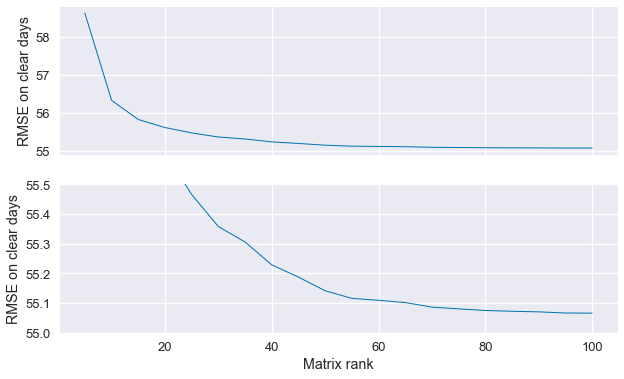

In [63]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)
axes[0].plot(ks, errors, linewidth=1)
axes[0].set_ylabel('RMSE on clear days')
axes[1].plot(ks, errors, linewidth=1)
axes[1].set_ylabel('RMSE on clear days')
axes[1].set_ylim(55, 55.5)
axes[1].set_xlabel('Matrix rank')

In [15]:
errors

array([58.62481471, 56.32401862, 55.81905478, 55.60731425, 55.46577157,
       55.35781428, 55.305895  , 55.22870604, 55.18745917, 55.14138375,
       55.11579666, 55.10925737, 55.10160692, 55.08624018, 55.08044582,
       55.07487339, 55.07229877, 55.07026383, 55.06644197, 55.06596137])

Text(0.5,0,u'5-minute intervals')

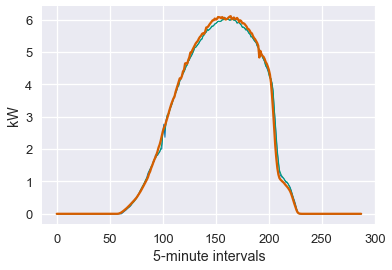

In [61]:
DAY = scs.cleardays[5]
scs.reconstruct_day(DAY, n=scs.DP_clearsky.shape[0])
estimates = scs.estimate_clearsky(np.s_[DAY%365:(DAY+1)%365])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i])
plt.ylabel('kW')
plt.xlabel('5-minute intervals')

Text(0.5,0,u'5-minute intervals')

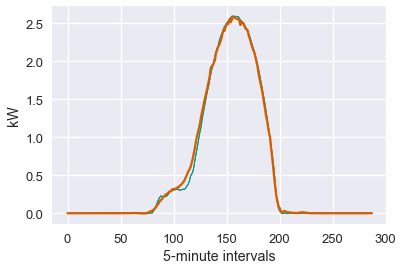

In [60]:
DAY = scs.cleardays[94]
scs.reconstruct_day(DAY, n=scs.DP_clearsky.shape[0])
estimates = scs.estimate_clearsky(np.s_[DAY%365:(DAY+1)%365])
for i in xrange(estimates.shape[1]):
    plt.plot(estimates[:, i])
plt.ylabel('kW')
plt.xlabel('5-minute intervals')